**Importing Important Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Defining Constants**

In [2]:
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 400
BATCH_SIZE = 32
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
data_dir  = "Building Types"
class_names = ['Bungalow','Highrise','Storey-Building']

**Pytorch**

**Importing Important Packages**

In [3]:
#Importing
import os


from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.optim as optim

import shutil  # For moving files

**Splitting the data**

In [ ]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Create the destination directories if they don't exist
for dir_name in [train_dir, val_dir, test_dir]:
    for class_name in os.listdir(data_dir): #Iterate through each class folder
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# Split the data
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)

    # Split into train and (val+test)
    train_files, temp_files = train_test_split(image_files, train_size=0.8, random_state=42)  # 80% train

    # Split the temp files into val and test
    val_files, test_files = train_test_split(temp_files, train_size=0.5, random_state=42)  # 50% of temp = 10% val, 10% test

    # Move files to respective directories
    for files, dest_dir in [(train_files, train_dir), (val_files, val_dir), (test_files, test_dir)]:
        for file_name in files:
            source_path = os.path.join(class_dir, file_name)
            destination_path = os.path.join(dest_dir, class_name, file_name) #Corrected the path
            shutil.move(source_path, destination_path)

print("Data split and organized successfully!")

Data split and organized successfully!


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize and crop for data augmentation
        transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally
        transforms.ToTensor(),              # Convert to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}


In [8]:
# Load datasets using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(eval(x + '_dir')), data_transforms[x]) for x in ['train', 'val']}

# Create data loaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes  # Get class names (building types)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.64].


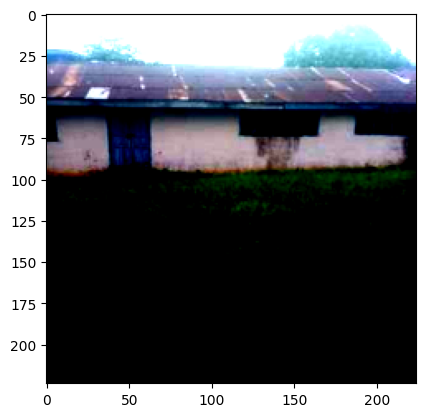

In [9]:
plt.imshow(image_datasets['train'][23][0].permute(1, 2, 0))

In [10]:
# Creating Model

# Use a pre-trained model (Transfer Learning)
model_ft = models.resnet18(pretrained=True)

# Modify the classifier (last fully connected layer)
num_classes = len(class_names)  # Number of building types
num_ftrs = model_ft.fc.in_features  # Get input features of the last layer
model_ft.fc = nn.Linear(num_ftrs, num_classes)  # Replace with a new linear layer

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [11]:
# 3. Training

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)  # You can use SGD, etc.

# Training loop (simplified)
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()  # Set model to training mode
        else:
            model_ft.eval()   # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            with torch.set_grad_enabled(phase == 'train'):  # Enable gradients only in training
                outputs = model_ft(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()  # Backpropagate the loss
                    optimizer.step()  # Update the weights

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

train Loss: 0.8032 Acc: 0.6632
val Loss: 2.4483 Acc: 0.5500
train Loss: 0.6066 Acc: 0.7333
val Loss: 0.4743 Acc: 0.8333
train Loss: 0.5038 Acc: 0.7573
val Loss: 0.3842 Acc: 0.8500
train Loss: 0.4538 Acc: 0.7960
val Loss: 0.7979 Acc: 0.8000
train Loss: 0.4732 Acc: 0.7877
val Loss: 0.3832 Acc: 0.8333
train Loss: 0.4441 Acc: 0.8149
val Loss: 0.4734 Acc: 0.8583
train Loss: 0.4229 Acc: 0.8222
val Loss: 0.3753 Acc: 0.8333
train Loss: 0.4239 Acc: 0.8232
val Loss: 0.4940 Acc: 0.7833
train Loss: 0.4051 Acc: 0.8368
val Loss: 0.4669 Acc: 0.8833
train Loss: 0.4178 Acc: 0.8075
val Loss: 0.4660 Acc: 0.8417


In [12]:
# Evaluation (on the test set)
model_ft.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 84.17%


In [15]:
import pickle
with open("./model/model_ft.pkl", 'wb') as model_file:
    pickle.dump(model_ft, model_file)